<a href="https://colab.research.google.com/github/MIBRivera/PCA-negative-PN/blob/main/Ohme_et_al_reproduction_of_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load pycbc and waveform plugin for modifying the waveforms
import sys
!{sys.executable} -m pip install pycbc ligo-common lalsuite --no-cache-dir
!{sys.executable} -m pip install git+https://github.com/gwastro/example-waveform-plugin
!{sys.executable} -m pip install gwent gwinc --no-cache-dir

#preliminaries
import pycbc
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.constants import golden_ratio
from scipy.interpolate import interp1d

import astropy.constants as const
import astropy.units as u

import gwent
import gwent.detector as detector
import gwent.binary as binary


#Turn off warnings for tutorial
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('seaborn-paper')


     |████████████████████████████████| 6.7 MB 3.8 MB/s 
     |████████████████████████████████| 46.2 MB 1.4 MB/s 
     |████████████████████████████████| 75 kB 35.0 MB/s 
     |████████████████████████████████| 1.6 MB 46.7 MB/s 
     |████████████████████████████████| 51 kB 37.8 MB/s 
     |████████████████████████████████| 201 kB 58.8 MB/s 
     |████████████████████████████████| 55 kB 35.7 MB/s 
     |████████████████████████████████| 3.6 MB 52.2 MB/s 
  Created wheel for lscsoft-glue: filename=lscsoft_glue-2.0.0-cp37-cp37m-linux_x86_64.whl size=416849 sha256=079ea70251cf12fc8f6a5fada260dbcd583778df41ffac55f4cc99368957ab30
  Stored in directory: /tmp/pip-ephem-wheel-cache-jepl696o/wheels/9d/ed/9e/1f9cad5e15359dc17954b893dd486760b5cb1ffd97a8405d1e
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp37-cp37m-linux_x86_64.whl size=86659 sha256=7513772fe309c327e00b3bb0272ca2c65ca3939ca9caac3578c2f0e45a5f6235
  Stored in directory: /tmp/pip-ephem-wheel-cache-jepl696o/wheels

In [2]:
# Constants

G = 6.67e-11 # Newton's Gravitational Constant, in m^3/kg/s^2
c = 2.99e8 # speed of light in m/s
Msun = 1.9884099021470415e+30 # mass of the sun in kg
Mpc = 3.085677581491367e+22 # Mpc in m

D_L = 5.183189e-7 # Mpc
m1 = 5 # primary mass in M_sun
m2 = 1.35 # secondary mass in M_sun
chi1 = 0.3 # primary dimensionless spin (c/G s/m_1^2)
chi2 = 0.0 # secondary dimensionless spin (c/G s/m_2^2)
f_delta = 1.0/4.0 # The frequency step used to generate the waveform (in Hz).
f_lower = 40 # The starting frequency of the waveform (in Hz).
approx = str('TaylorF2') # GW approximant to be used
M = m1 + m2 # total mass (in source frame)
mu = (m1*m2)/M # reduced mass of the system
eta = mu/M # symmetric mass ratio
m_chirp = M*(eta**(3/5)) # chirp mass
# tau_c = (5/256*eta)*(G*M/c**3)*(np.pi*G*M*f_lower/c**3)**(-8/3) # time at coalescence in terms of initial GW frequency in [s], eq. 3.178c of Creighton
# phi_c = 0.0 # phase at coalescence (default)
tau_c = 0
phi_c = -np.pi/4
chi_eff = (m1*chi1 + m2*chi2)/M # effective spin

In [3]:
# Get a vacuum frequency domain waveform
from pycbc import waveform

hptilde, hctilde = waveform.get_fd_waveform(approximant=approx,
                             mass1=m1, mass2=m2, delta_f=f_delta, f_lower=f_lower, distance=D_L, spin1z=chi1)

In [4]:
print(hptilde)

[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... -9.33315318e-17+1.04055123e-16j
 -9.38469960e-17+1.03510959e-16j -9.43588293e-17+1.02964763e-16j]


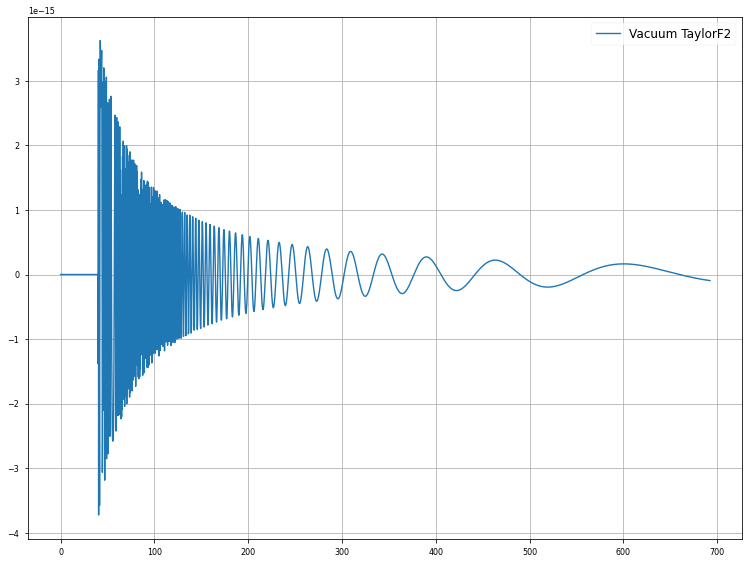

In [5]:
plt.figure(0, figsize=(12.8,9.6))
# plt.plot(LISA_prop1.fT.value, hptilde_LISA.real, 'o', label='Vacuum IMRPhenom (interpolated)')
plt.plot(hptilde.sample_frequencies, hptilde.real(), label='Vacuum TaylorF2')
plt.legend(fontsize='large')
plt.grid()
# plt.xlim(0,0.0001)
# plt.ylim(-1e-20,1e-20)

In [6]:
# hp, hc = hptilde.trim_zeros(), hctilde.trim_zeros()
# phase = waveform.utils.phase_from_polarizations(hp, hc)
# plt.figure(1,figsize=(12.8,9.6))
# plt.plot(hptilde.sample_frequencies, phase)

In [7]:
# Copyright (C) 2020  Ssohrab Borhanian
# 
# This program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# 
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.


# import numpy as np
import sympy as sp

# import gwbench.basic_relations as brs
# from gwbench.basic_constants import time_fac, strain_fac

cos = sp.cos
sin = sp.sin
log = sp.log
PI = np.pi

wf_symbs_string = 'f Mc eta chi1z chi2z DL tc phic iota'
f, Mc, eta, chi1z, chi2z, DL, tc, phic, iota = sp.symbols(wf_symbs_string, real=True)
# f = sp.symbols('f', seq=True)

#------from Anruadha--------
# defining constants
GammaE = 0.577215664901532

def hfpc(f, Mc, eta, chi1z, chi2z, DL, tc, phic, iota):
    '''
    Mc ... in solar mass
    DL ... in mega parsec
    '''
    # convert to sec
    Mc = Mc * (G*Msun/c**3)
    DL = DL * Mpc/c

    # get sym and asym chi combinations
    chi_s = 0.5*(chi1z+chi2z)
    chi_a = 0.5*(chi1z-chi2z)

    '''
    Mc is in sec, e.g., Mc = 10*MTSUN_SI (for 10 solar mass)
    DL is in sec, e.g., DL = 100*1e6*PC_SI/C_SI (for 100 Mpc)
    '''

    M = Mc/eta**(3./5.)
    delta = (1.-4.*eta)**0.5
    v  = (PI*M*f)**(1./3.)
    flso = 1./6.**(3./2.)/PI/M
    vlso = (PI*M*flso)**(1./3.)
    A =((5./24.)**0.5/PI**(2./3.))*(Mc**(5./6.)/DL) # in units of s^-1/6, Restricted PN approximation

    # 3.5PN phasing (point particle limit)
    p0 = 1.

    p1 = 0

    p2 = (3715./756. + (55.*eta)/9.)

    p3 = (-16.*PI + (113.*delta*chi_a)/3. + (113./3. - (76.*eta)/3.)*chi_s)

    p4 = (15293365./508032. + (27145.*eta)/504.+ (3085.*eta**2)/72. + (-405./8. + 200.*eta)*chi_a**2 - (405.*delta*chi_a*chi_s)/4. + (-405./8. + (5.*eta)/2.)*chi_s**2)

    gamma = (732985./2268. - 24260.*eta/81. - 340.*eta**2/9.)*chi_s + (732985./2268. + 140.*eta/9.)*delta*chi_a

    p5 = (38645.*PI/756. - 65.*PI*eta/9. - gamma)

    p5L = (38645.*PI/756. - 65.*PI*eta/9. - gamma)*3*log(v/vlso)

    p6 = (11583231236531./4694215680. - 640./3.*PI**2 - 6848./21.*GammaE + eta*(-15737765635./3048192. + 2255./12.*PI**2) + eta*eta*76055./1728. - eta*eta*eta*127825./1296. \
         - (6848./21.)*log(4.) + PI*(2270.*delta*chi_a/3. + (2270./3. - 520.*eta)*chi_s) + (75515./144. - 8225.*eta/18.)*delta*chi_a*chi_s \
         + (75515./288. - 263245.*eta/252. - 480.*eta**2)*chi_a**2 + (75515./288. - 232415.*eta/504. + 1255.*eta**2/9.)*chi_s**2)

    p6L = -(6848./21.)*log(v)

    p7 = (((77096675.*PI)/254016. + (378515.*PI*eta)/1512.- (74045.*PI*eta**2)/756. + (-25150083775./3048192. + (10566655595.*eta)/762048. - (1042165.*eta**2)/3024. + (5345.*eta**3)/36.
         + (14585./8. - 7270.*eta + 80.*eta**2)*chi_a**2)*chi_s + (14585./24. - (475.*eta)/6. + (100.*eta**2)/3.)*chi_s**3 + delta*((-25150083775./3048192.
         + (26804935.*eta)/6048. - (1985.*eta**2)/48.)*chi_a + (14585./24. - 2380.*eta)*chi_a**3 + (14585./8. - (215.*eta)/2.)*chi_a*chi_s**2)))

    phase = 2*f*PI*tc - phic - PI/4. + (3./(128.*v**5*eta))*(p0 + v*p1 + v**2*p2 + v**3*p3+ v**4*p4 + v**5*(p5+p5L) + v**6*(p6+p6L) + v**7*p7)

    hp = 0.5*(1+(cos(iota))**2)*A*f**(-7./6.)*(cos(phase) - 1j*sin(phase)) # in units of s
    hc = -1j*cos(iota)*A*f**(-7./6.)*(cos(phase) - 1j*sin(phase))

    return hp, hc, phase


In [8]:
# f=np.linspace(15,700,10000)

Ohme_hp=hfpc(f,(6.35*((5*1.35)/6.35**2)**(3/5)),((5*1.35)/6.35**2),0.3,0,5.183189e-7,0,-PI/4,0)[0]

In [9]:
print(hfpc(f,(6.35*((5*1.35)/6.35**2)**(3/5)),eta,0.3,0,5.183189e-7,0,-PI/4,0)[0].diff(eta))
print(hfpc(f,Mc,((5*1.35)/6.35**2)**(3/5),0.3,0,5.183189e-7,0,-PI/4,0)[0].diff(Mc))

2.88541189641994e-13*f**(-1.16666666666667)*(-(661076.911181786*eta**(-2.0)*(eta**(-0.6)*f)**(-1.66666666666667)*(0.00104680001053384*(eta**(-0.6)*f)**0.666666666666667*(6.11111111111111*eta + 4.91402116402116) + 3.38684699663364e-5*(eta**(-0.6)*f)**1.0*(-3.8*eta + 11.3*(0.25 - eta)**0.5 - 44.6154824574367) + 1.09579026205364e-6*(eta**(-0.6)*f)**1.33333333333333*(42.8472222222222*eta**2 + 58.415376984127*eta - 4.55625*(0.25 - eta)**0.5 + 27.8250279509952) + 3.54535147175259e-8*(eta**(-0.6)*f)**1.66666666666667*(5.66666666666667*eta**2 + 22.2366456499996*eta - 0.3*(0.25 - eta)**0.5*(15.5555555555556*eta + 323.185626102293) + (17.0*eta**2 + 66.7099369499989*eta - 0.9*(0.25 - eta)**0.5*(15.5555555555556*eta + 323.185626102293) + 336.339674991974)*log(0.0792514988072972*(eta**(-0.6)*f)**0.333333333333333) + 112.113224997325) + 1.14707325786063e-9*(eta**(-0.6)*f)**2.0*(-98.6304012345679*eta**3 + 36.3508101851852*eta**2 - 3587.24446215589*eta + 0.045*(0.25 - eta)**0.5*(524.409722222222 - 456

In [20]:
hp_numpy = sp.lambdify(f,hfpc(f,(6.35*((5*1.35)/6.35**2)**(3/5)),((5*1.35)/6.35**2),0.3,0,2.3525e-9,0,-PI/4,0)[0],'numpy')
print(hp_numpy(692))

(-1.50740483921066e-14+3.3647174814864274e-15j)


In [11]:
print(sp.re(Ohme_hp))

-2.88541189641994e-13*(-sin(12.3074220796669*log(Abs(f)) + 661076.911181786*re(f**(-1.66666666666667)) + 8398.11708916986*re(f**(-1.0)) - 2748.42614352861*re(f**(-0.666666666666667)) + 113.487452337933*re(f**(-0.333333333333333)) + 4.55411706348177*re(f**0.333333333333333) - 0.13594960776287*re(f**0.666666666666667) - 0.703977469185261*re(f**0.333333333333333*log(f)) - 68.0965551693164)*sinh(661076.911181786*im(f**(-1.66666666666667)) + 8398.11708916986*im(f**(-1.0)) - 2748.42614352861*im(f**(-0.666666666666667)) + 113.487452337933*im(f**(-0.333333333333333)) + 4.55411706348177*im(f**0.333333333333333) - 0.13594960776287*im(f**0.666666666666667) - 0.703977469185261*im(f**0.333333333333333*log(f)) + 12.3074220796669*arg(f)) - 1.0*sin(12.3074220796669*log(Abs(f)) + 661076.911181786*re(f**(-1.66666666666667)) + 8398.11708916986*re(f**(-1.0)) - 2748.42614352861*re(f**(-0.666666666666667)) + 113.487452337933*re(f**(-0.333333333333333)) + 4.55411706348177*re(f**0.333333333333333) - 0.1359496

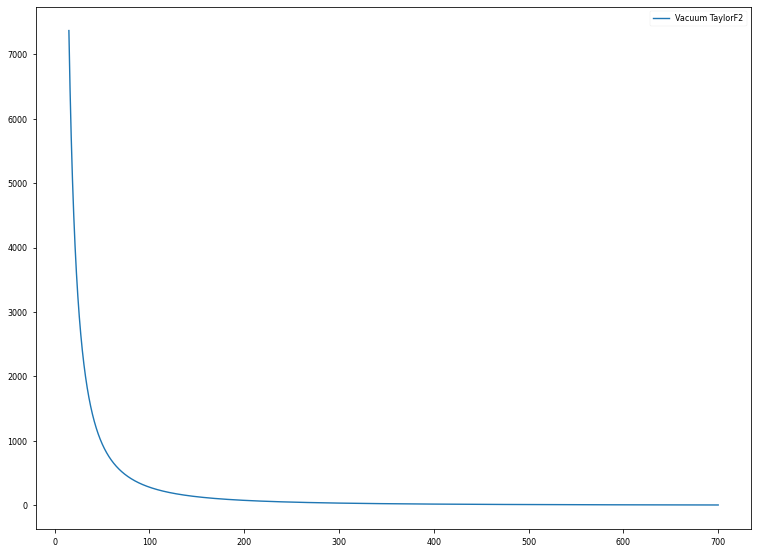

In [14]:
f_array=np.linspace(15,700,10000)
Ohme_phase=np.zeros(len(f_array))

for n in range(len(f_array)):
    Ohme_phase[n] = sp.N(sp.re(hfpc(f,(6.35*((5*1.35)/6.35**2)**(3/5)),((5*1.35)/6.35**2),0.3,0,5.183189e-7,0,-PI/4,0)[2]).subs(f, f_array[n]))

# plt.title('Signal')
plt.figure(4, figsize=(12.8,9.6))
plt.plot(f_array, Ohme_phase, label='Vacuum TaylorF2')
plt.legend()
# plt.show()

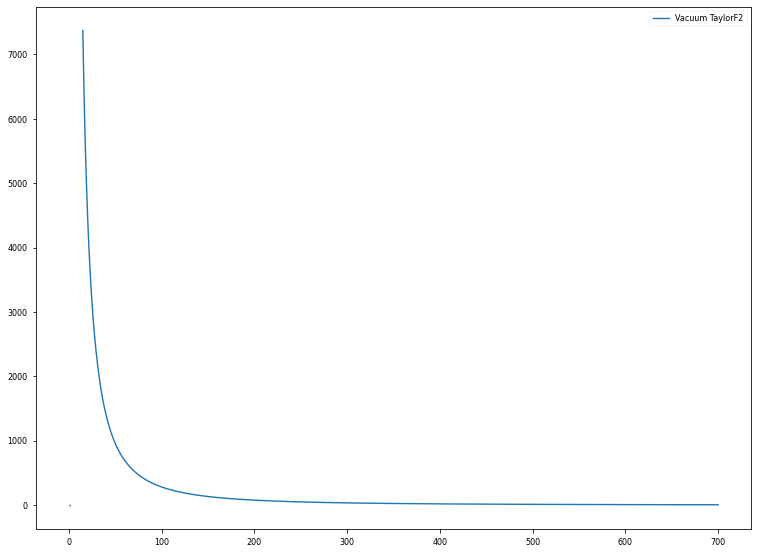

In [28]:
plt.figure(5, figsize=(12.8,9.6))
plt.plot(f_array, Ohme_phase, label='Vacuum TaylorF2')
plt.hlines(0,0,1)
plt.legend()

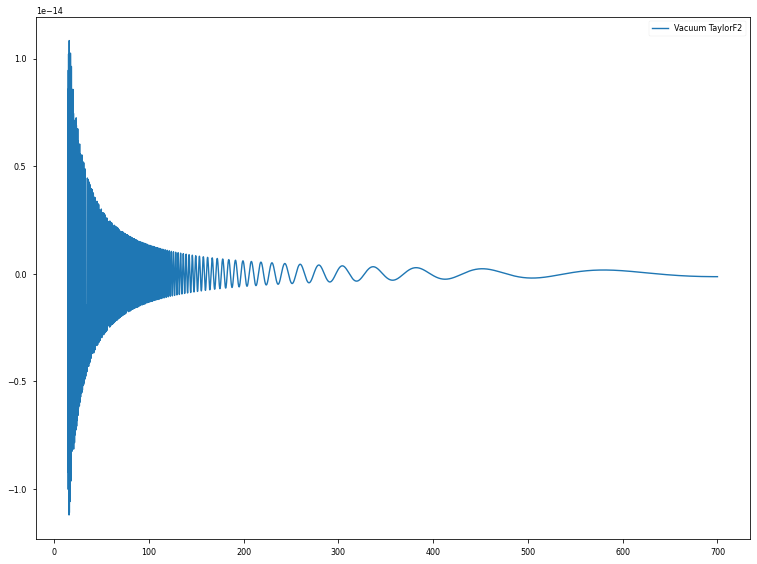

In [15]:
f_array=np.linspace(15,700,10000)
Ohme_f=np.zeros(len(f_array))

for n in range(len(f_array)):
    Ohme_f[n] = sp.N(sp.re(Ohme_hp).subs(f, f_array[n]))

# plt.title('Signal')
plt.figure(2, figsize=(12.8,9.6))
plt.plot(f_array, Ohme_f, label='Vacuum TaylorF2')
plt.legend()
# plt.show()

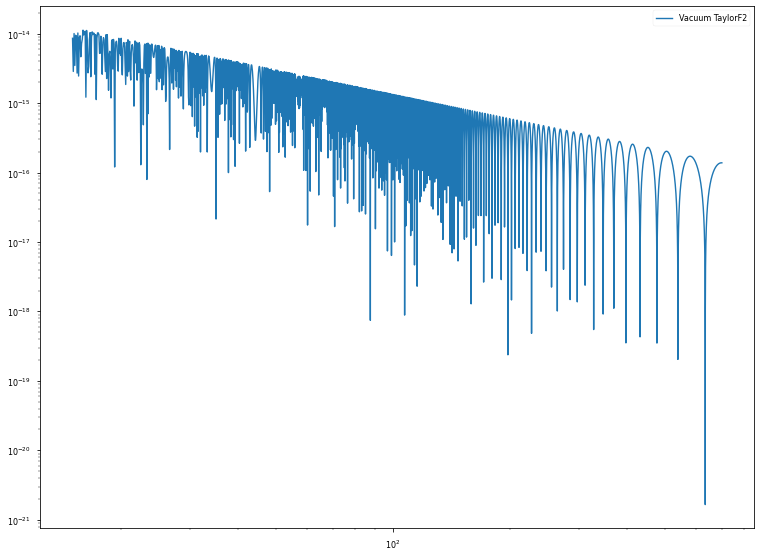

In [16]:
plt.figure(3, figsize=(12.8,9.6))
plt.plot(f_array, abs(Ohme_f), label='Vacuum TaylorF2')
plt.legend()
# plt.xlim(15,20)
plt.yscale('log')
plt.xscale('log')

Fisher attempts

In [17]:
# from scipy.integrate import quad


def overlap(Noise, h1, h2, f1, f2):
  '''
  Returns a real float with the overlap integral evaluated.

  Noise: array-like with 2 columns, frequency at first column and PSD in the second
  h1: lambdified sympy expression to numpy array
  h2: lambdified sympy expression to numpy array
  '''

  f_arr = np.linspace(f1,f2,len(Noise[:,1]))

  integrand = np.divide(np.multiply(h1(f_arr),np.conjugate(h2(f_arr))), Noise[:,1])
  
  return 4*np.real(np.sum(integrand)), integrand, f_arr

In [21]:
zerodet = np.loadtxt('ZERO_DET_high_P.txt')
# print(zerodet[0,1])

SNR = overlap(zerodet, hp_numpy, hp_numpy, 15, 691.8351241383538)
print(SNR[0])
print(SNR[1])
print(len(SNR[2]))
print(len(zerodet[:,1]))

7.041192586693473
[1.04823739e-03+0.j 8.09061623e-04+0.j 5.81157290e-04+0.j ...
 6.79616716e-06+0.j 6.77570935e-06+0.j 6.75531422e-06+0.j]
3000
3000


Just a check: Cardoso's result for a BBH in the LIGO band

In [22]:
hp_CM = sp.lambdify(f,hfpc(f,(66.2*((35.6*30.6)/66.2**2)**(3/5)),((35.6*30.6)/66.2**2),-0.01,-0.01,430,0,-PI/4,0)[0],'numpy')

SNR_sq = overlap(zerodet, hp_CM, hp_CM, 10, 110.633)
print(np.sqrt(SNR_sq[0]))

1.4980082553626782e-09


A BNS in the LIGO band

In [23]:
hp_CM2 = sp.lambdify(f,hfpc(f,(2.73*((1.46*1.27)/2.73**2)**(3/5)),((1.46*1.27)/2.73**2),-0.01,0,40,0,-PI/4,0)[0],'numpy')

SNR_sq2 = overlap(zerodet, hp_CM2, hp_CM2, 10, 2679.24)
print(np.sqrt(SNR_sq2[0]))

5.379788015102632e-11


Our SPP SNR results

In [26]:
# gwent preliminaries for executing LISA detector noise strain

L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')
LISA_T_obs = 4*u.yr
f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
A_acc = 3e-15*u.m/u.s/u.s
A_IMS = 10e-12*u.m

Background = False

LISA_prop1 = detector.SpaceBased('LISA',\
                          LISA_T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                          Background=Background)
LISA_prop1_Snf = (LISA_prop1.h_n_f.value)**2/(LISA_prop1.fT.value) #convert h_n(f) to S_n(f), consult Moore et. al 2015, CQG 015014

In [27]:
print(LISA_prop1_Snf)

[1.96966608e-27 1.95071181e-27 1.93193993e-27 ... 6.64229386e-38
 6.85916815e-38 7.12854972e-38]
